In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from importlib import reload

import tensorflow as tf

In [2]:
import domain
import network
import PINN

## Sampling points in the domain

<IPython.core.display.Javascript object>


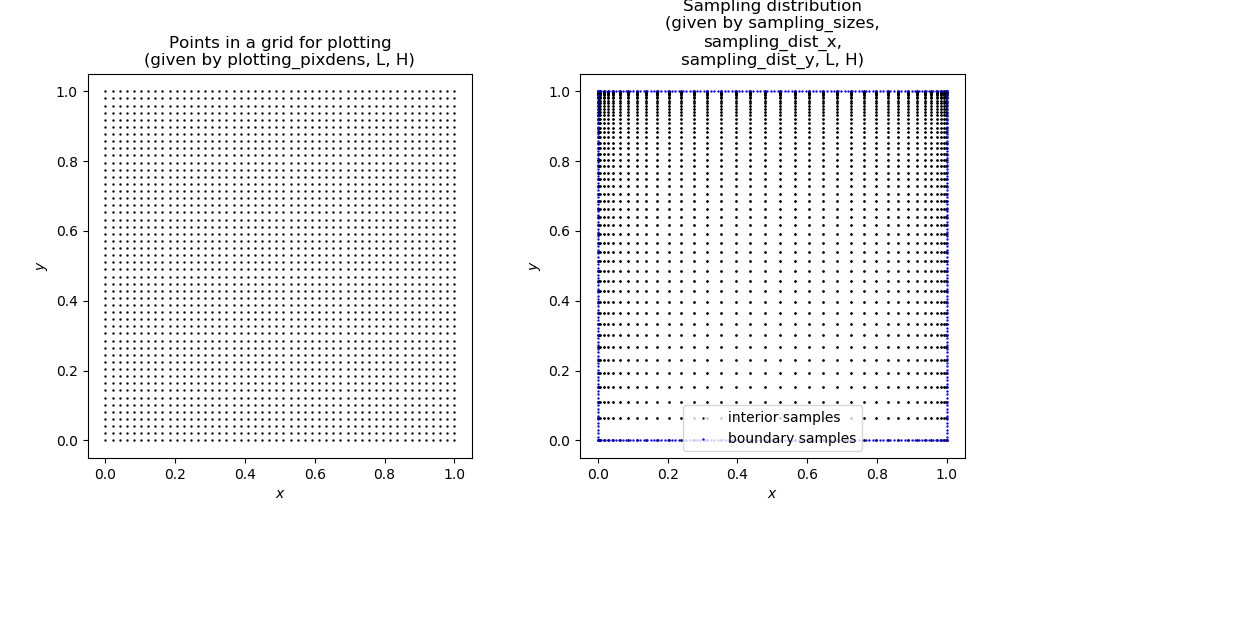

In [3]:
reload(domain)

# Domain dimensions
L     = 1
H     = 1

D    = domain.rectangular_domain(L=L, H=H, plotting_pixdens = 50, sampling_sizes = (75,50),
                                 sampling_dist_x = lambda x: np.sin(np.pi*x)**2,
                                 sampling_dist_y = lambda y: np.sin(np.pi*y/2)**0.8)

fig, axs = plt.subplots(1,2, figsize = (10*L,5*H))

axs[0].set_title("Points in a grid for plotting\n(given by plotting_pixdens, L, H)")
axs[0].scatter(D.plotting_grid[:,0], D.plotting_grid[:,1], s = 0.5, color = 'k')

D.update_samples()

axs[1].set_title("Sampling distribution\n(given by sampling_sizes,\nsampling_dist_x,\nsampling_dist_y, L, H)")
axs[1].scatter(D.interior_samples[:,0],D.interior_samples[:,1], s = 0.5, c = 'k', label = 'interior samples')
axs[1].scatter(D.boundary_samples[:,0],D.boundary_samples[:,1], s = 0.5, c = 'b', label = 'boundary samples')
axs[1].legend()

for ax in axs:
    ax.set_xlabel("$x$")
    ax.set_ylabel("$y$")
    ax.set_aspect('equal','box')
    
fig.tight_layout()
fig.canvas.draw();

fig.savefig('sampling_yeet.png')

## The network architecture

<IPython.core.display.Javascript object>


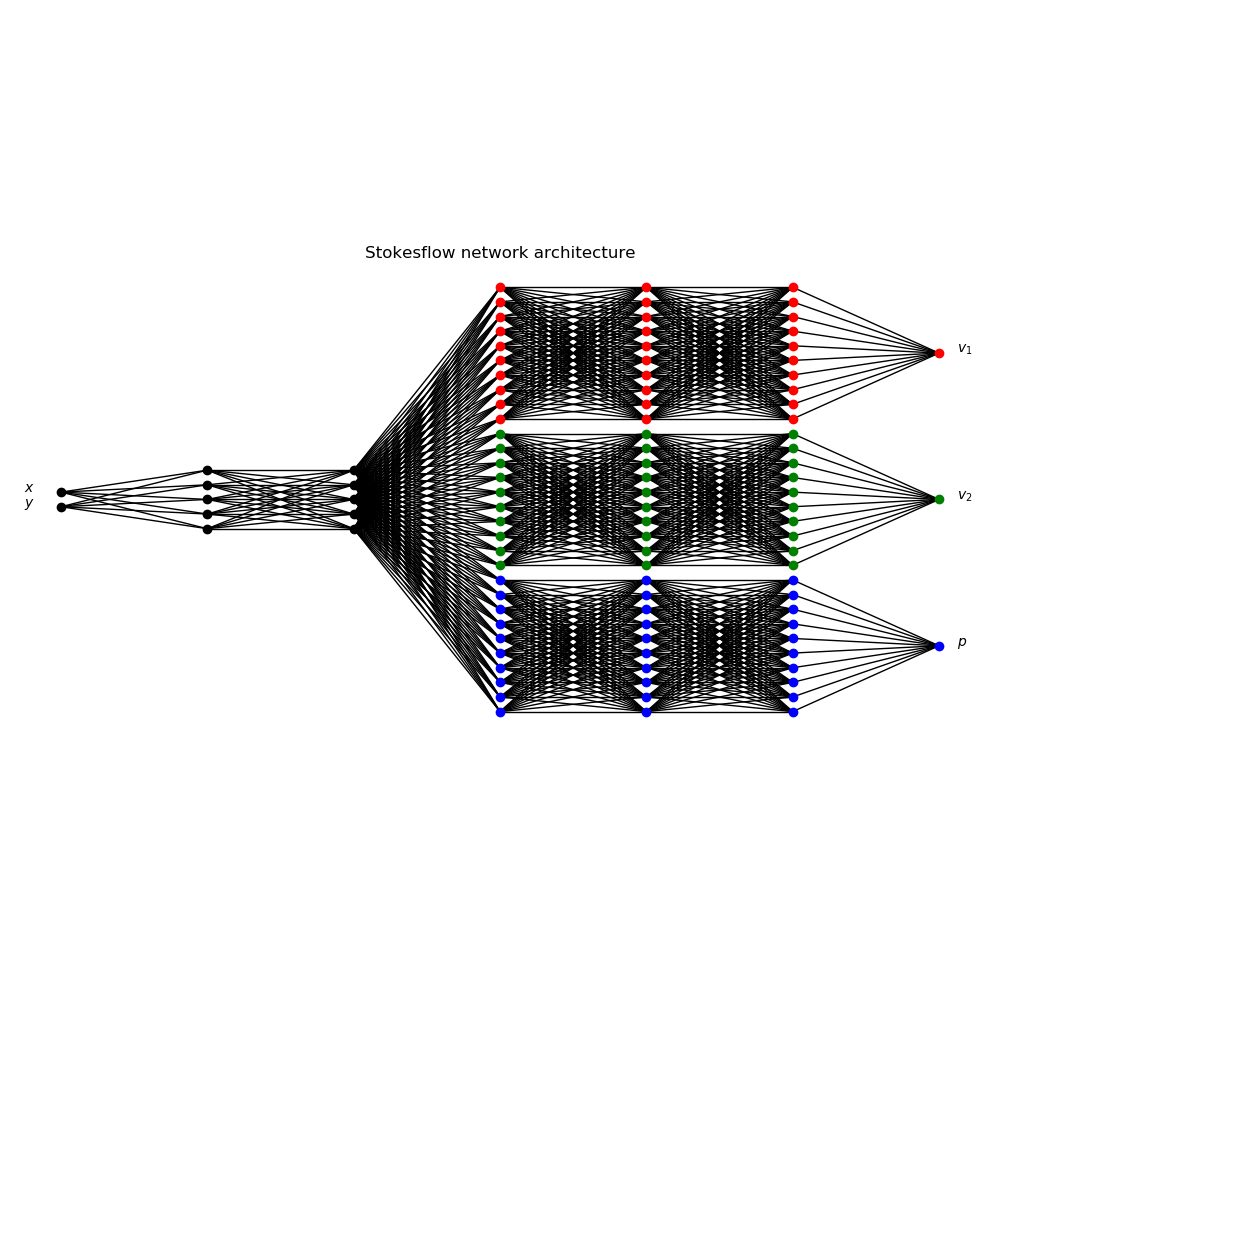

Model: "stokesflow_branched"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 2)]          0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 5)            15          input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 5)            30          dense[0][0]                      
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 1)            6           dense_1[0][0]                    
________________________________________________________________________________

In [4]:
reload(network)
reload(PINN)

# Note: here we use the second class form both the network and the PINN scripts, the first one is for the warm-up exericse

# Model = network.construct_model_stokesflow(hidden_layer_widths = np.array(7*[10]),
#                                            activation_function = tf.nn.tanh)

model_assembler = network.model_stokesflow_branched(branch_widths = 3*[10])
model_assembler.plot_model(spacing_x = 10, figsize = (10,10))
Model = model_assembler.assemble_full_model()
Model.summary()

# Optimizer = tf.keras.optimizers.Adam(learning_rate=0.001,
#                                      beta_1=0.99,
#                                      epsilon=1e-7)
Optimizer = tf.keras.optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=1e-08)

# Defining functions that descrive the boundary conditions (in order left, right, top bottom, standard is all 0)
BCs_v1    = 4*[lambda x: 0*x]
BCs_v1[2] = lambda x: 0*x +1

# Standard we have f = 0
# The loss weights are in the order incompressibility, PDE, boundaries

loss_weights = np.array([10,1,10])
loss_weights = loss_weights/np.sum(loss_weights) # always normalize weights

NN = PINN.PINN_object_stokesflow(D, Model, Optimizer, BCs_v1 = BCs_v1, loss_weights = loss_weights)
NN.compute_f_and_BC_values()

## Training

<IPython.core.display.Javascript object>


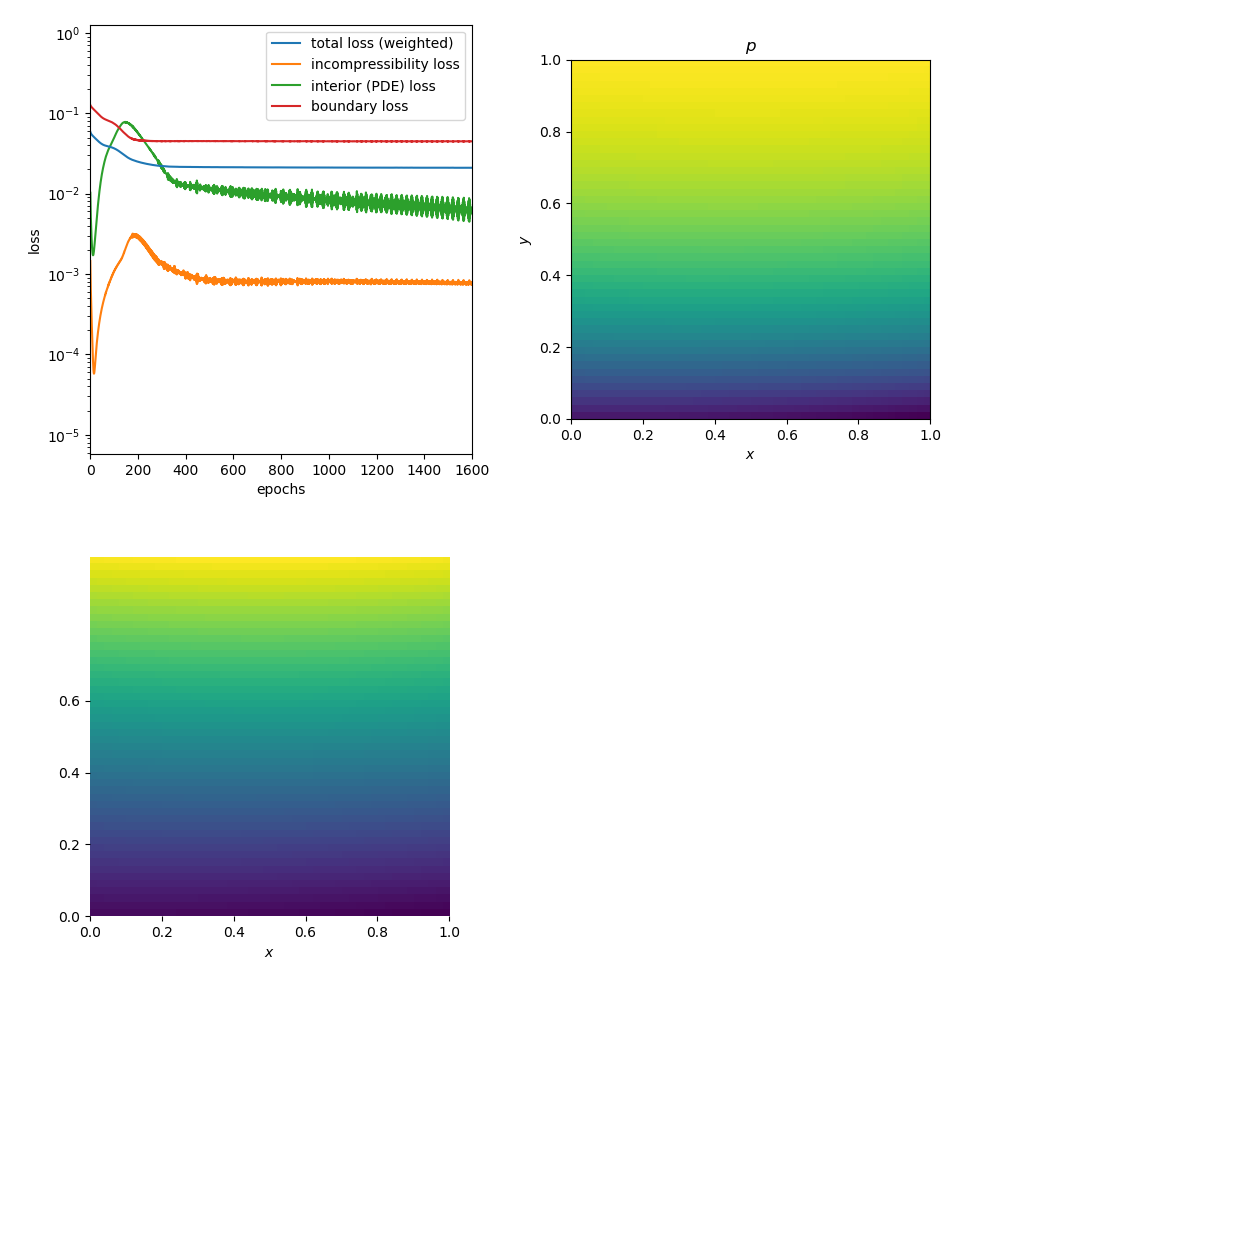

KeyboardInterrupt: 

In [5]:
NN.fit(n_epochs = 10000,
       plot_update_interval = 50);

## Gridsearch

In [9]:
from itertools import product
import csv
import numpy as np
import tensorflow as tf
import domain
import network
import PINN

n_epochs       = 100
stem_lengths   = range(6)
stem_widths    = range(1,6)
branch_lengths = range(1,6)
branch_widths  = range(1,6)
learning_rate  = 1e-2
loss_weights   = [10,1,100]

# Domain
D = domain.rectangular_domain(sampling_sizes = (75,50),
                              sampling_dist_x = lambda x: np.sin(np.pi*x)**2,
                              sampling_dist_y = lambda y: np.sin(np.pi*y/2)**0.8)

# Boundary conditions
BCs_v1    = 4*[lambda x: 0*x]
BCs_v1[2] = lambda x: 0*x +1

Parameter_combinations = list(product(stem_lengths,
                                      stem_widths,
                                      branch_lengths,
                                      branch_widths))

no_param_combis = len(Parameter_combinations)
print(f'Number of parameter combinations: {no_param_combis}')

Number of parameter combinations: 750


In [ ]:
with open('gridsearch_log.csv', mode = 'w', newline = '') as csv_file:
    
    writer = csv.writer(csv_file, delimiter = ',')
    writer.writerow(['final_loss','stem_length','stem_width','branch_length','branch_width','learning_rate'])

    for i, (stem_length, stem_width, branch_length, branch_width) in enumerate(Parameter_combinations):

        # Set up model
        model_assembler = network.model_stokesflow_branched(stem_widths   = stem_length*[stem_width],
                                                            branch_widths = branch_length*[branch_width])
        Model     = model_assembler.assemble_full_model()
        Optimizer = tf.keras.optimizers.RMSprop(lr=learning_rate, rho=0.9, epsilon=1e-08)
        NN        = PINN.PINN_object_stokesflow(D, Model, Optimizer, BCs_v1 = BCs_v1, loss_weights = loss_weights)

        # Training
        NN.fit(n_epochs = n_epochs, show_progress = False);

        # Save data
        final_loss = NN.losses_total[-1]
        data       = [final_loss,stem_length,stem_width,branch_length,branch_width,learning_rate]
        writer.writerow(data)
        print(f'({i+1}/{no_param_combis}): {data}')

In [35]:
import pandas as pd

gridsearch_data = pd.read_csv('gridsearch_log.csv')
gridsearch_data

,final_loss,stem_length,stem_width,branch_length,branch_width,learning_rate,weight_incompressibility,weight_PDE,weight_BCS
0,0.028996,0,1,1,1,0.100,0.333333,0.333333,0.333333
1,0.218651,0,1,1,1,0.100,0.083333,0.083333,0.833333
2,0.214105,0,1,1,1,0.100,0.009804,0.009804,0.980392
3,0.108261,0,1,1,1,0.100,0.000998,0.000998,0.998004
4,3.365561,0,1,1,1,0.100,0.083333,0.833333,0.083333
...,...,...,...,...,...,...,...,...,...
645,0.185304,0,1,2,1,0.001,0.833333,0.083333,0.083333
646,0.050760,0,1,2,1,0.001,0.476190,0.047619,0.476190
647,0.087613,0,1,2,1,0.001,0.090090,0.009009,0.900901
648,0.172082,0,1,2,1,0.001,0.009891,0.000989,0.989120


In [42]:
min_loss_index = gridsearch_data['final_loss'].idxmin()
gridsearch_data.iloc[min_loss_index]

final_loss                  0.000217
stem_length                 0.000000
stem_width                  1.000000
branch_length               2.000000
branch_width                1.000000
learning_rate               0.010000
weight_incompressibility    0.998004
weight_PDE                  0.000998
weight_BCS                  0.000998
Name: 622, dtype: float64